In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math


In [ ]:
def read_grid_from_file(file_path):
    grid = []
    starts_goals=[]
    lineNumber =0
    with open(file_path, 'r') as file:
        for line in file:
            lineNumber+=1
            if 2<lineNumber<6:
                line_split = line.strip().split()
                start = line_split[3]
                start = ( int(start[1:-1].split(",")[1]), int(start[1:-1].split(",")[0]))
                goal = line_split[6]
                goal = ( int(goal[1:-1].split(",")[1]), int(goal[1:-1].split(",")[0]))
                starts_goals.append([start,goal])
            if lineNumber>5:
                line_split = list(line.strip())
                if len(line_split)==0:
                    continue
                # Strip the newline character and split by spaces
                grid.append(line_split)
    return grid,starts_goals

In [6]:
import heapq
class PriorityQueue:
    def __init__(self):
        self.heap = []
        self.updated = set()
        self.visited = set()
    
    def push(self, item, priority):
        heapq.heappush(self.heap, (priority, item))
    
    def decrease_priority(self, item, oldPriority, newPriority):
        heapq.heappush(self.heap, (newPriority, item))
        self.updated.add((oldPriority,item))

    def decrease_priority_a_star(self, item, oldPriority, newPriority):
        '''
        Special optimization for A* algorithm
        '''
        heapq.heappush(self.heap, (newPriority, item))
        if oldPriority!=float('inf'):
            self.updated.add((oldPriority,item))
        
    def pop(self):
        priority, item = heapq.heappop(self.heap)
        # Lazy Deletion: we loop and pop off (remove) any items that have been updated until we have a valid item
        # No impact to performance if decrease_priority is not called
        while (priority, item) in self.updated:
            priority, item = heapq.heappop(self.heap)
        return priority, item
        
    def peek(self):
        return self.heap[0]

    def is_empty(self):
        return len(self.heap) == 0

In [5]:

import matplotlib.pyplot as plt
import numpy as np
def plot_grid(ax,grid, path=None, start=None, goal=None):
    # Create a color map for the grid
    cmap = plt.cm.get_cmap('Greys').copy()
    cmap.set_under(color='white') # Free space color
    cmap.set_over(color='black') # Obstacle color
    grid_array = np.asarray(grid)
    #fig, ax = plt.subplots()
    # Plot the grid with respect to the upper left-hand corner
    ax.matshow(grid_array, cmap=cmap, vmin=0.1, vmax=1.0, origin='lower')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(-0.5, len(grid[0]), 1))
    ax.set_yticks(np.arange(-0.5, len(grid), 1))
    ax.set_xticklabels(range(0, len(grid[0])+1))
    ax.set_yticklabels(range(0, len(grid)+1))
    # Plot the path with direction arrows
    if path:
        for i in range(len(path) - 1):
            start_y,start_x = path[i]
            end_y, end_x  = path[i + 1]
            ax.arrow(start_x, start_y, end_x - start_x, end_y - start_y,
                head_width=0.3, head_length=0.3, fc='blue', ec='blue')
        # Plot the last point in the path
        ax.plot(path[-1][1], path[-1][0], 'b.')
        # Plot the start and goal points
        if start:
            ax.plot(start[1], start[0], 'go') # Start point in green
        if goal:
            ax.plot(goal[1], goal[0], 'ro') # Goal point in red
        
    #return fig


In [7]:
def neighbors_four():
    return [[-1,0], #up
            [0,1], #right
            [1,0], #down
            [0,-1] #left
            ]

def neighbors_8():
    return [[-1,0,0], #up
            [0,1,0],  #right
            [1,0,0],  #down
            [0,-1,0], #left
            
            [-1,1,1], #right-up
            [1,1,1],  #right-down
            [1,-1,1], #left-down
            [-1,-1,1] #left-up
            ]

def get_neighbors(curr, grid):
    possible_neighbors = neighbors_8()
    
    #possible_neighbors = neighbors_four()
    #possible_neighbors.reverse()
    neighbors = []
    for pn in possible_neighbors:
        row = curr[0] + pn[0]
        col = curr[1] + pn[1]
        if 0 <= row < len(grid) and 0 <= col < len(grid[0]) and grid[row][col] == 0:
            # Special logic for 8 directions for diagonal movement to avoid obstacles
            if pn[2]==1:
                if grid[curr[0]+pn[0]][curr[1]]==0 and grid[curr[0]][curr[1]+pn[1]]==0:
                    neighbors.append((row, col))
            else:
                neighbors.append((row, col))
    return neighbors



In [8]:

def run_algo(algorithm,start,goal,grid_numerical):
    # grid, start_goals = read_grid_from_file(mapFile)
    # grid_numerical = [[1 if cell == 'X' else 0 for cell in row] for row in grid]
    # grid_numerical = np.flipud(grid_numerical)
    # for start,goal in start_goals:
    #     #start_flip = (len(grid_numerical)-1-start[0],start[1])
    #     #goal_flip = (len(grid_numerical)-1-goal[0],goal[1])
    # start_flip = start
    # goal_flip = goal
    path,counter = algorithm(start,goal,grid_numerical)
    #plot_grid(grid_numerical,path,start,goal)
    return path,counter

def plot_metrics(algos: dict,metric: str,xLabel,yLabel,title):
    barWidth = 0.1666
    
    mapCount = 4 #len(algos[list(algos.keys())[0]]["stats"])
    goalCount = 3
    bar_x=[]
    br1 = np.arange(goalCount) 
    bar_x.append(br1)
    br2 = [x + barWidth for x in br1] 
    bar_x.append(br2)
    br3 = [x + barWidth for x in br2] 
    bar_x.append(br3)
    br4 = [x + barWidth for x in br3] 
    bar_x.append(br4)
    br5 = [x + barWidth for x in br4] 
    bar_x.append(br5)
    br6 = [x + barWidth for x in br5] 
    bar_x.append(br6)

    for rangeIndex in range(0,mapCount):
        fig, ax = plt.subplots()
        barIndex = 0
        for algo in algos:
            stat = algos[algo]["stats"][rangeIndex]
            plt.bar(bar_x[barIndex],stat[metric],label=f"{algo} on {stat['map']}",width=barWidth)
            barIndex+=1
        plt.xticks([r + barWidth for r in range(len(stat[metric]))],['1', '2', '3'])
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.title(title)
        plt.legend()
        plt.show()

def run_single_algo(map,algo):
    grid, start_goals = read_grid_from_file(map)
    grid_numerical = [[1 if cell == 'X' else 0 for cell in row] for row in grid]
    grid_numerical = np.flipud(grid_numerical)
    for start,goal in start_goals:
        run_algo(algo,start,goal,grid_numerical)


In [10]:

def dijkstra_optimized(start, goal, grid_numerical):
    
    queue_to_visit:PriorityQueue = PriorityQueue()
    costs = {}
    costs[start]=0
    queue_to_visit.push(start,0)
    for i in range(0,len(grid_numerical)):
        for j in range(0,len(grid_numerical[0])):
            state = (i,j)
            if state!=start:
                costs[state]=float('inf')
                # We don't need to push all states to the queue, save some RAM!
    
    predecessor_map={}
    path = []
    curr = None
    counter = 0
    
    while queue_to_visit:
        cost_to_come, curr = queue_to_visit.pop()
        counter+=1
        if curr == goal:
            while True:
                path.append(curr)
                if curr == start:
                    path = path[::-1]
                    return path, counter
                curr = predecessor_map[curr]
        neighbors = get_neighbors(curr, grid_numerical)
        for n in neighbors:
            tentative_cost = cost_to_come+1
            if tentative_cost<costs[n]:
                queue_to_visit.push(n,tentative_cost)
                costs[n]=tentative_cost
                predecessor_map[n]=curr
            
    return None, counter

def dijkstra(start, goal, grid_numerical):
    visited = set()
    queue_to_visit:PriorityQueue = PriorityQueue()
    costs = {}
    
    costs[start]=0
    queue_to_visit.push(start,0)
    for i in range(0,len(grid_numerical)):
        for j in range(0,len(grid_numerical[0])):
            state = (i,j)
            if state!=start:
                costs[state]=float('inf')
                queue_to_visit.push(start,float('inf'))
    visited.add(start)
    predecessor_map={}
    path = []
    curr = None
    counter = 0
    
    while queue_to_visit:
        cost_to_come, curr = queue_to_visit.pop()
        counter+=1
        if curr == goal:
            while True:
                path.append(curr)
                if curr == start:
                    path = path[::-1]
                    return path, counter
                curr = predecessor_map[curr]
        neighbors = get_neighbors(curr, grid_numerical)
        for n in neighbors:
            tentative_cost = cost_to_come+1
            if tentative_cost<costs[n]:
                queue_to_visit.decrease_priority(n,costs[n],tentative_cost)
                costs[n]=tentative_cost
                predecessor_map[n]=curr
            
    return None, counter

def uniform_cost_search(start, goal, grid_numerical):
    '''
    https://web.archive.org/web/20200218150951/https://www.aaai.org/ocs/index.php/SOCS/SOCS11/paper/viewFile/4017/4357
    '''
    closed = set()
    queue_to_visit = PriorityQueue()
    pathway={}
    path = []
    costs = {}
    queue_to_visit.push(start,0)
    costs[start]=0

    for i in range(0,len(grid_numerical)):
        for j in range(0,len(grid_numerical[0])):
            state = (i,j)
            if state!=start:
                costs[state]=float('inf')
    curr = None
    counter = 0

    while queue_to_visit:
        cost_to_come, curr = queue_to_visit.pop()
        counter+=1
        if curr == goal:
            while True:
                path.append(curr)
                if curr == start:
                    path = path[::-1]
                    return path, counter
                curr = pathway[curr]
        neighbors = get_neighbors(curr, grid_numerical)
        for n in neighbors:
            newCost = cost_to_come+1
            # Check if the cost to come is less than the old cost
            oldCost = costs[n]
            if newCost<oldCost and n not in closed: # we only process the node if it is not in the closed set and its a better path
                queue_to_visit.push(n,newCost)
                costs[n]=newCost
                pathway[n]=curr
        closed.add(curr)
    return None, counter

SQUARE_ROOT_2 = math.sqrt(2)
def heuristic(node,goal):
    # For 4 directions
    # return abs(node[0]-goal[0])+abs(node[1]-goal[1])

    # For 8 directions see: https://www.geeksforgeeks.org/a-search-algorithm/
    dx = abs(node[0]-goal[0])
    dy = abs(node[1]-goal[1])
    return (dx+dy)+ (SQUARE_ROOT_2-2)*min(dx,dy)

def a_star(start, goal, grid_numerical):
    '''
    https://en.wikipedia.org/wiki/A*_search_algorithm
    '''
    closed = set()
    queue_to_visit = PriorityQueue()
    pathway={}
    path = []
    costs = {}
    costs_to_come = {}
    start_node_cost = 0+heuristic(start,goal)
    queue_to_visit.push(start,0+heuristic(start,goal))
    costs[start]=start_node_cost
    costs_to_come[start]=0
    for i in range(0,len(grid_numerical)):
        for j in range(0,len(grid_numerical[0])):
            state = (i,j)
            if state!=start:
                costs[state]=float('inf')
                costs_to_come[state]=float('inf')
    curr = None
    counter = 0

    while queue_to_visit:
        _ , curr = queue_to_visit.pop()
        counter+=1
        if curr == goal:
            while True:
                path.append(curr)
                if curr == start:
                    path = path[::-1]
                    return path, counter
                curr = pathway[curr]
        neighbors = get_neighbors(curr, grid_numerical)
        for n in neighbors:
            # Small optimization to avoid reprocessing the node
            if n in closed:
                continue
            new_cost_to_come_g_score = costs_to_come[curr]+1
            # Heuristic cost is from the neighbor to the goal!
            new_f_score = new_cost_to_come_g_score+heuristic(n,goal)
            old_f_score = costs[n]
            # old_cost_to_come_g_score = costs_to_come[n]
            if new_f_score<old_f_score:
                queue_to_visit.decrease_priority_a_star(n,old_f_score,new_f_score)
                costs[n]=new_f_score
                costs_to_come[n]=new_cost_to_come_g_score
                pathway[n]=curr
        closed.add(curr)
    return None, counter


def breath_first_search(start, goal, grid_numerical):
    visited = set()
    queue_to_visit = [start]
    visited.add(start)
    pathway={}
    path = []
    curr = None
    counter = 0
    while queue_to_visit:
        curr = queue_to_visit.pop(0)
        counter+=1
        if curr == goal:
            while True:
                path.append(curr)
                if curr == start:
                    path = path[::-1]
                    return path, counter
                curr = pathway[curr]
        neighbors = get_neighbors(curr, grid_numerical)
        for n in neighbors:
            if n not in visited:
                queue_to_visit.append(n)
                visited.add(n)
                pathway[n]=curr
    return None, counter

def depth_first_search(start, goal, grid_numerical):
    visited = set()
    queue_to_visit = [start]
    visited.add(start)
    pathway={} # dictionary to store the path to previous node
    path = [] #final list of path
    curr = None
    counter = 0
    while queue_to_visit:
        curr = queue_to_visit.pop()
        counter+=1
        if curr == goal:
            while True:
                path.append(curr)
                if curr == start:
                    path = path[::-1]
                    return path, counter
                curr = pathway[curr]
                
        neighbors = get_neighbors(curr, grid_numerical)
        for n in neighbors:
            if n not in visited:
                queue_to_visit.append(n)
                visited.add(n)
                pathway[n]=curr
    return None,counter


In [15]:
def setup():
    algorithms = {
        "BFS": {
            "algorithm": breath_first_search,
            "stats": 
                [
                    {
                    "map": "./maps/map1.txt",
                    "execution_times": [],
                    "visited_states_count": [],
                    "memory_usage": []
                    },
                    {
                    "map": "./maps/map2.txt",
                    },
                    {
                    "map": "./maps/map3.txt",
                    }
                    ,
                    {
                    "map": "./maps/map4.txt",
                    }

                ]
         
        },
        "DFS": {
            "algorithm": depth_first_search,
            "stats": 
                [
                    {
                    "map": "./maps/map1.txt",
                    },
                    {
                    "map": "./maps/map2.txt",
                    },
                    {
                    "map": "./maps/map3.txt",
                    }
                    ,
                    {
                    "map": "./maps/map4.txt",
                    }

                ]
            },
        "Dijkstras": {
            "algorithm": dijkstra,
            "stats": 
                [
                    {
                    "map": "./maps/map1.txt",
                    },
                    {
                    "map": "./maps/map2.txt",
                    },
                    {
                    "map": "./maps/map3.txt",
                    }
                    ,
                    {
                    "map": "./maps/map4.txt",
                    }

                ]
        },
        "Uniform Cost Search": {
            "algorithm": uniform_cost_search,
            "stats": 
                [
                    {
                    "map": "./maps/map1.txt",
                    },
                    {
                    "map": "./maps/map2.txt",
                    },
                    {
                    "map": "./maps/map3.txt",
                    }
                    ,
                    {
                    "map": "./maps/map4.txt",
                    }

                ]
        },
        "Dijkstras_Optimized": {
            "algorithm": dijkstra_optimized,
            "stats": 
                [
                    {
                    "map": "./maps/map1.txt",
                    },
                    {
                    "map": "./maps/map2.txt",
                    },
                    {
                    "map": "./maps/map3.txt",
                    }
                    ,
                    {
                    "map": "./maps/map4.txt",
                    }

                ]
        },
        "A Star": {
            "algorithm": a_star,
            "stats": 
                [
                    {
                    "map": "./maps/map1.txt",
                    },
                    {
                    "map": "./maps/map2.txt",
                    },
                    {
                    "map": "./maps/map3.txt",
                    }
                    ,
                    {
                    "map": "./maps/map4.txt",
                    }

                ]
        }
        
    }
    
    
    return algorithms


In [16]:
def pathPlanningAnalysis():
    algos = setup()
    # Uncomment to run only one algorithm
    # algos = {"BFS":algos.get("BFS")}
    import time
    for algo in algos:
        mapCount = len(algos[algo]["stats"])
        
        grid, start_goals = read_grid_from_file(algos[list(algos.keys())[0]]["stats"][0]["map"])
        goals = len(start_goals)
        fig, axs = plt.subplots(mapCount, goals)
        mapIndex = 0
        
        for stat in algos[algo]["stats"]:
            print(f"Running {algo} on {stat['map']}")
            grid, start_goals = read_grid_from_file(stat['map'])
            grid_numerical = [[1 if cell == 'X' else 0 for cell in row] for row in grid]
            grid_numerical = np.flipud(grid_numerical)
            goalIndex = 0
            for start,goal in start_goals:
                start_time = time.time()
                path, visited_states_count = run_algo(algos[algo]["algorithm"],start,goal,grid_numerical)
                end_time = time.time()
                execution_time = end_time - start_time
                
                if stat.get("path_length") is None:
                    stat["path_length"] = []
                stat["path_length"].append(len(path))
                plot_grid(axs[mapIndex,goalIndex],grid_numerical,path,start,goal)    
                
                if stat.get("execution_times") is None:
                    stat["execution_times"] = []
                stat["execution_times"].append(execution_time)
                
                if stat.get("visited_states_count") is None:
                    stat["visited_states_count"] = []
                stat["visited_states_count"].append(visited_states_count)
                
                print(f"Execution Time: {execution_time} seconds")
                print(f"Visited states count: {visited_states_count}")
                goalIndex+=1
            mapIndex+=1
        fig.suptitle(f"{algo}")
        plt.show()

    return algos


Running BFS on ./maps/map1.txt
Execution Time: 0.00029778480529785156 seconds
Visited states count: 78
Execution Time: 0.00024318695068359375 seconds
Visited states count: 62
Execution Time: 0.00039076805114746094 seconds
Visited states count: 77
Running BFS on ./maps/map2.txt
Execution Time: 0.0007126331329345703 seconds
Visited states count: 173
Execution Time: 0.0005040168762207031 seconds
Visited states count: 141
Execution Time: 0.0005586147308349609 seconds
Visited states count: 158
Running BFS on ./maps/map3.txt
Execution Time: 0.002857208251953125 seconds
Visited states count: 735


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was

Execution Time: 0.002626180648803711 seconds
Visited states count: 508
Execution Time: 0.0004088878631591797 seconds
Visited states count: 112
Running BFS on ./maps/map4.txt
Execution Time: 0.01139378547668457 seconds
Visited states count: 2991


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()


Execution Time: 0.010824441909790039 seconds
Visited states count: 2784
Execution Time: 0.015012025833129883 seconds
Visited states count: 3001


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()


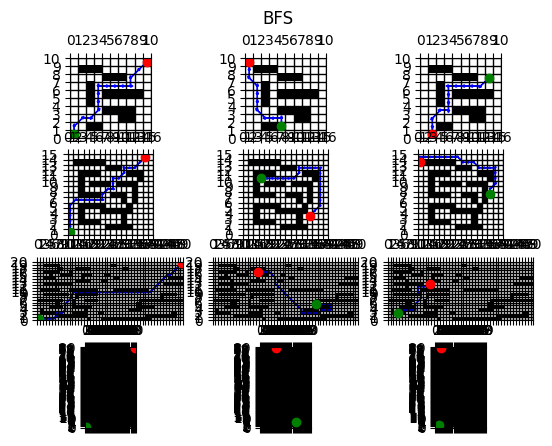

Running DFS on ./maps/map1.txt
Execution Time: 0.00012159347534179688 seconds
Visited states count: 29
Execution Time: 0.00018143653869628906 seconds
Visited states count: 47
Execution Time: 0.00010442733764648438 seconds
Visited states count: 17
Running DFS on ./maps/map2.txt
Execution Time: 0.00038313865661621094 seconds
Visited states count: 103
Execution Time: 0.0003638267517089844 seconds
Visited states count: 94
Execution Time: 0.00047898292541503906 seconds
Visited states count: 133
Running DFS on ./maps/map3.txt


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was

Execution Time: 0.0009529590606689453 seconds
Visited states count: 255
Execution Time: 0.002454519271850586 seconds
Visited states count: 621
Execution Time: 0.0028030872344970703 seconds
Visited states count: 703
Running DFS on ./maps/map4.txt


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()


Execution Time: 0.003538846969604492 seconds
Visited states count: 914
Execution Time: 0.010880231857299805 seconds
Visited states count: 2690


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()


Execution Time: 0.0011911392211914062 seconds
Visited states count: 283


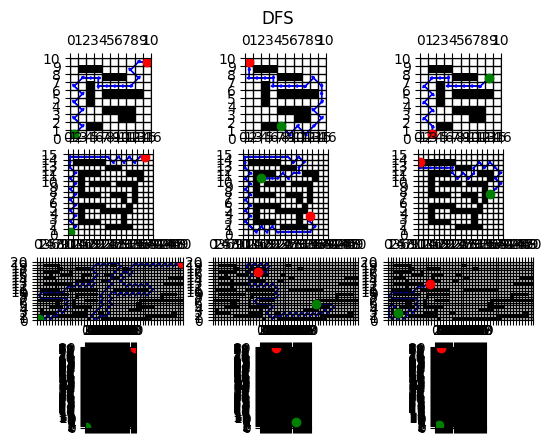

Running Dijkstras on ./maps/map1.txt
Execution Time: 0.0004115104675292969 seconds
Visited states count: 78
Execution Time: 0.00031757354736328125 seconds
Visited states count: 62
Execution Time: 0.00036454200744628906 seconds
Visited states count: 77
Running Dijkstras on ./maps/map2.txt
Execution Time: 0.0008294582366943359 seconds
Visited states count: 173
Execution Time: 0.0006587505340576172 seconds
Visited states count: 138
Execution Time: 0.0007388591766357422 seconds
Visited states count: 158
Running Dijkstras on ./maps/map3.txt
Execution Time: 0.0038514137268066406 seconds
Visited states count: 740


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was

Execution Time: 0.09572005271911621 seconds
Visited states count: 486
Execution Time: 0.0009405612945556641 seconds
Visited states count: 114
Running Dijkstras on ./maps/map4.txt
Execution Time: 0.015906572341918945 seconds
Visited states count: 2994
Execution Time: 0.01545405387878418 seconds
Visited states count: 2801
Execution Time: 0.015593290328979492 seconds
Visited states count: 3002


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()


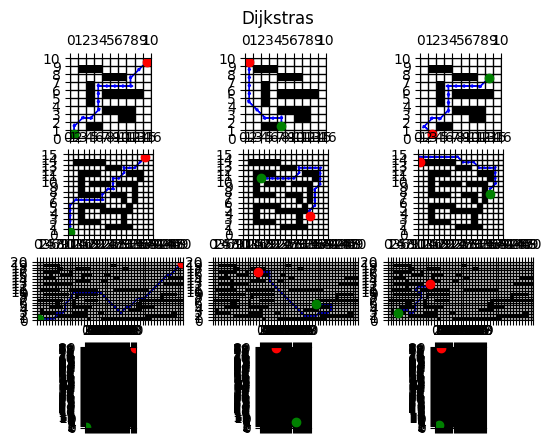

Running Uniform Cost Search on ./maps/map1.txt
Execution Time: 0.0008695125579833984 seconds
Visited states count: 78
Execution Time: 0.00030040740966796875 seconds
Visited states count: 62
Execution Time: 0.0006196498870849609 seconds
Visited states count: 77
Running Uniform Cost Search on ./maps/map2.txt
Execution Time: 0.0007402896881103516 seconds
Visited states count: 173
Execution Time: 0.0005941390991210938 seconds
Visited states count: 138
Execution Time: 0.0007181167602539062 seconds
Visited states count: 158
Running Uniform Cost Search on ./maps/map3.txt


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was

Execution Time: 0.0039103031158447266 seconds
Visited states count: 740
Execution Time: 0.003228425979614258 seconds
Visited states count: 486
Execution Time: 0.0006353855133056641 seconds
Visited states count: 114
Running Uniform Cost Search on ./maps/map4.txt


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()


Execution Time: 0.01487278938293457 seconds
Visited states count: 2994
Execution Time: 0.014574766159057617 seconds
Visited states count: 2801
Execution Time: 0.015233993530273438 seconds
Visited states count: 3002


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()


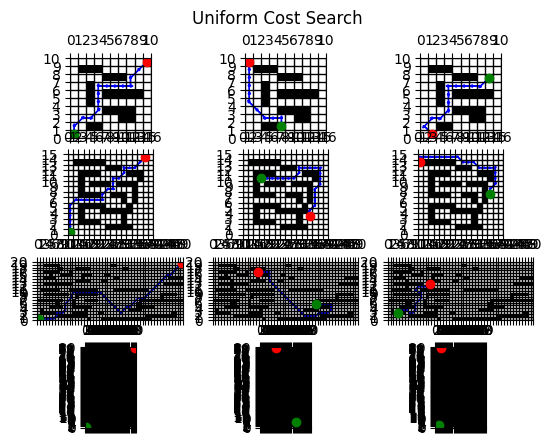

Running Dijkstras_Optimized on ./maps/map1.txt
Execution Time: 0.00042319297790527344 seconds
Visited states count: 78
Execution Time: 0.0003056526184082031 seconds
Visited states count: 62
Execution Time: 0.0003361701965332031 seconds
Visited states count: 77
Running Dijkstras_Optimized on ./maps/map2.txt
Execution Time: 0.0011196136474609375 seconds
Visited states count: 173
Execution Time: 0.0006277561187744141 seconds
Visited states count: 138
Execution Time: 0.0006742477416992188 seconds
Visited states count: 158
Running Dijkstras_Optimized on ./maps/map3.txt
Execution Time: 0.0033822059631347656 seconds
Visited states count: 740


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was

Execution Time: 0.002370595932006836 seconds
Visited states count: 486
Execution Time: 0.0006616115570068359 seconds
Visited states count: 114
Running Dijkstras_Optimized on ./maps/map4.txt
Execution Time: 0.014311552047729492 seconds
Visited states count: 2994
Execution Time: 0.014014244079589844 seconds
Visited states count: 2801


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was

Execution Time: 0.014835834503173828 seconds
Visited states count: 3002


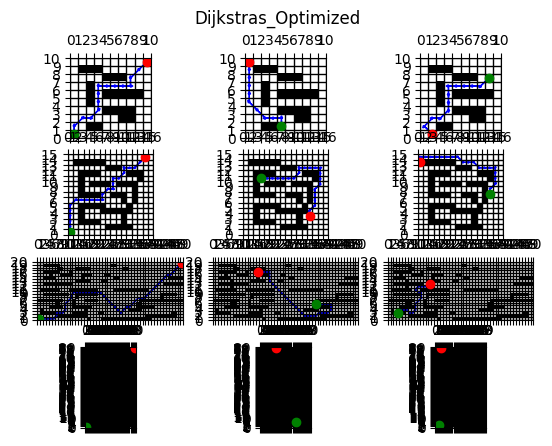

Running A Star on ./maps/map1.txt
Execution Time: 0.0002694129943847656 seconds
Visited states count: 32
Execution Time: 0.00019097328186035156 seconds
Visited states count: 16
Execution Time: 0.00015282630920410156 seconds
Visited states count: 20
Running A Star on ./maps/map2.txt
Execution Time: 0.00044155120849609375 seconds
Visited states count: 60
Execution Time: 0.08851480484008789 seconds
Visited states count: 66
Execution Time: 0.0004010200500488281 seconds
Visited states count: 48
Running A Star on ./maps/map3.txt


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was

Execution Time: 0.000766754150390625 seconds
Visited states count: 84
Execution Time: 0.0006594657897949219 seconds
Visited states count: 53
Execution Time: 0.0005774497985839844 seconds
Visited states count: 67
Running A Star on ./maps/map4.txt
Execution Time: 0.01067805290222168 seconds
Visited states count: 1394


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()
/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was

Execution Time: 0.002696990966796875 seconds
Visited states count: 285
Execution Time: 0.008779764175415039 seconds
Visited states count: 1242


/tmp/ipykernel_316969/1411203245.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys').copy()


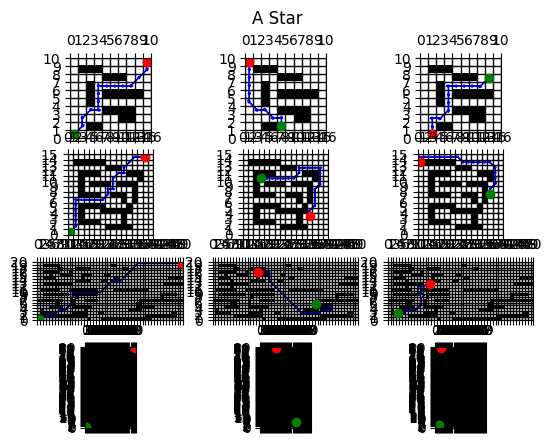

In [17]:
algos = pathPlanningAnalysis()

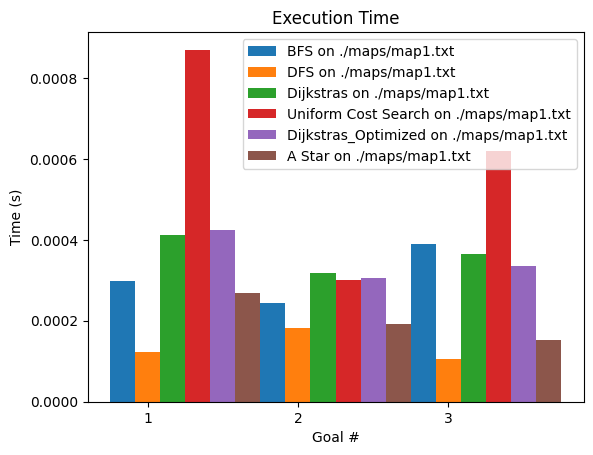

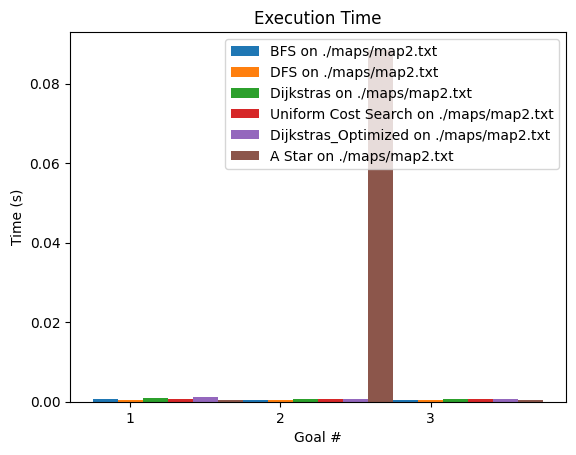

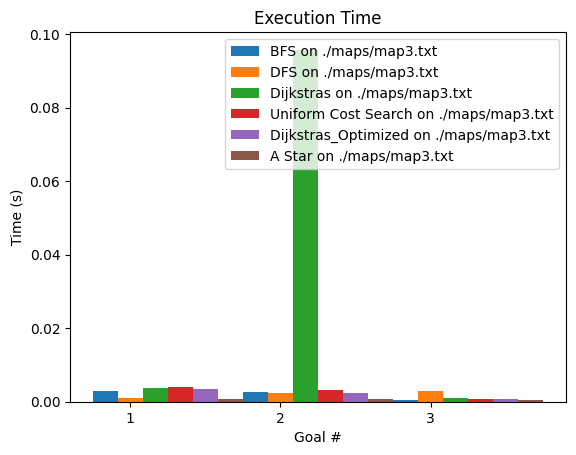

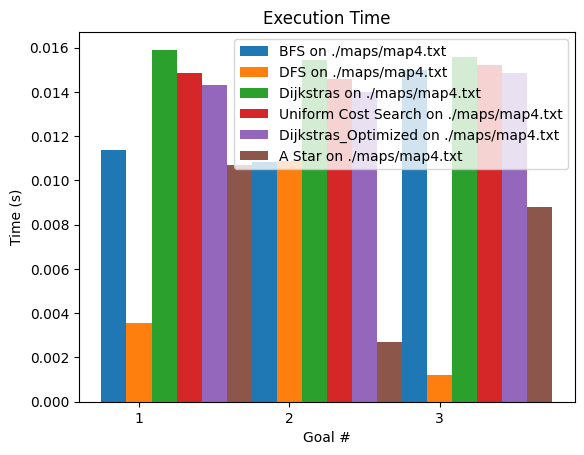

In [18]:
plot_metrics(algos,"execution_times","Goal #","Time (s)","Execution Time")


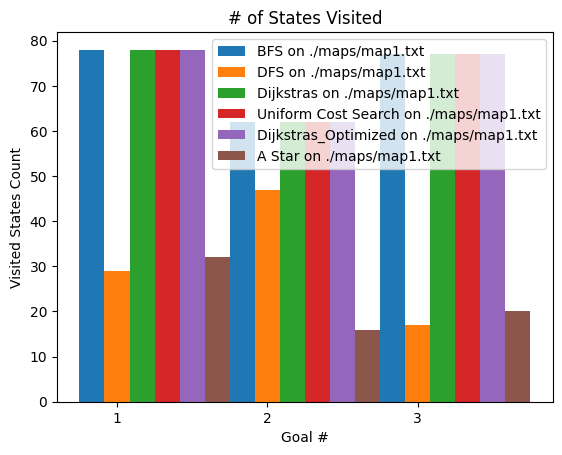

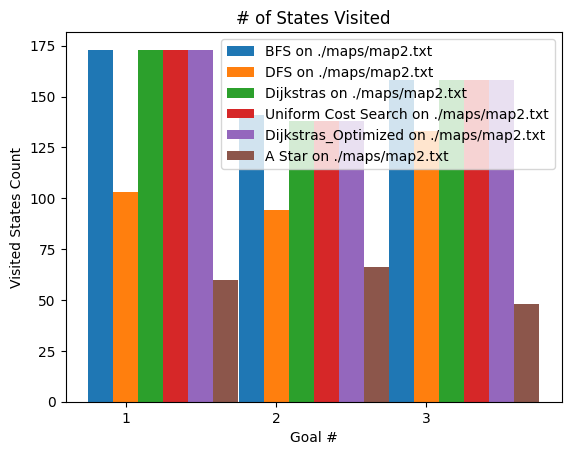

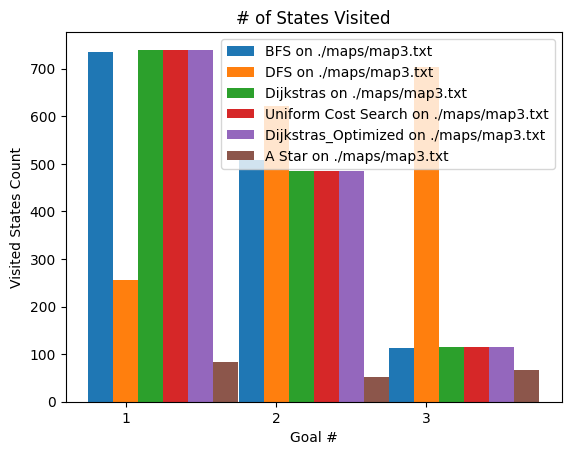

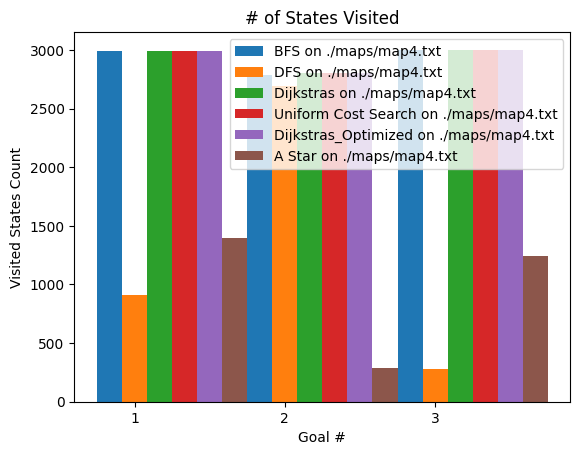

In [19]:
plot_metrics(algos,"visited_states_count","Goal #","Visited States Count","# of States Visited")


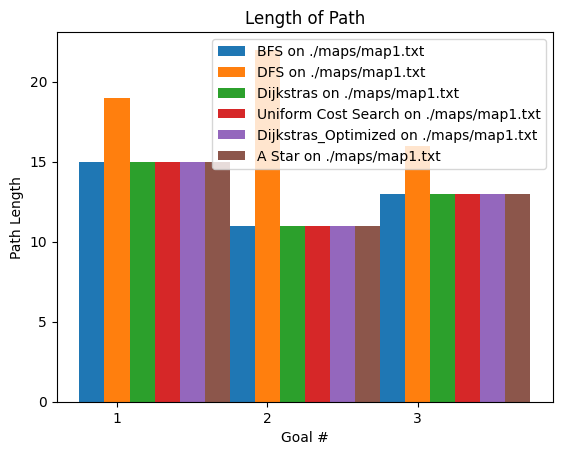

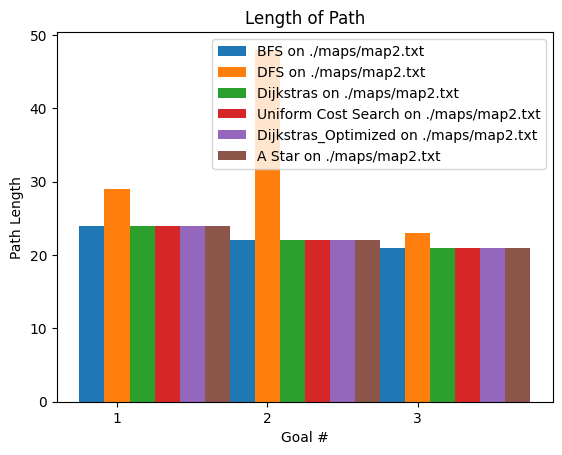

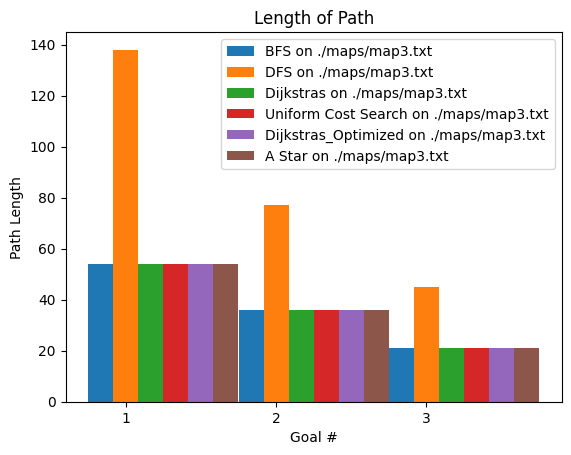

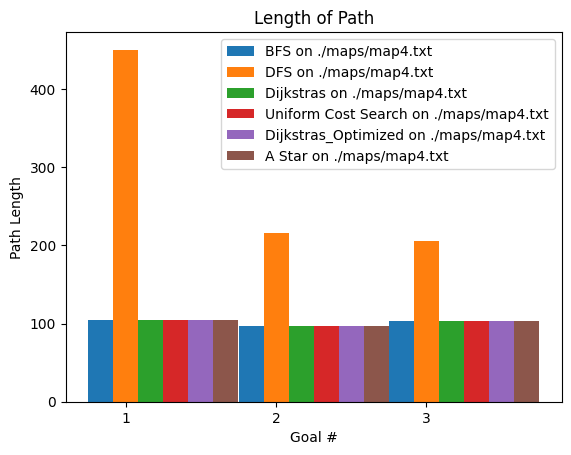

In [20]:
plot_metrics(algos,"path_length","Goal #","Path Length","Length of Path")